In [1]:
import copy
import numpy as np
from skimage.transform import downscale_local_mean

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

import plotly.graph_objects as px


# File names

In [2]:
input_file = "mars_map.IMG"
output_file = "mars_map.npy"

# Load map data

In [3]:
data_file = open(input_file, "rb")

endHeader = False;
while not endHeader:
    line = data_file.readline().rstrip().lower()

    sep_line = line.split(b'=')
       
    if len(sep_line) == 2:
        itemName = sep_line[0].rstrip().lstrip()
        itemValue = sep_line[1].rstrip().lstrip()

        if itemName == b'valid_maximum':
            maxV = float(itemValue)
        elif itemName == b'valid_minimum':
            minV = float(itemValue)
        elif itemName == b'lines':
            n_rows = int(itemValue)
        elif itemName == b'line_samples':
            n_columns = int(itemValue)
        elif itemName == b'map_scale':
            scale_str = itemValue.split()
            if len(scale_str) > 1:
                scale = float(scale_str[0])

    elif line == b'end':
        endHeader = True
        char = 0
        while char == 0 or char == 32:
            char = data_file.read(1)[0]      
        pos = data_file.seek(-1, 1)

image_size = n_rows*n_columns
data = data_file.read(4*image_size)

image_data = np.frombuffer(data, dtype=np.dtype('f'))
image_data = image_data.reshape((n_rows, n_columns))
image_data = np.array(image_data)
image_data = image_data.astype('float64')

image_data = image_data - minV;
image_data[image_data < -10000] = -1;


# Subsampling

In [4]:
sub_rate = round(10/scale) 

image_data = downscale_local_mean(image_data, (sub_rate, sub_rate))
image_data[image_data<0] = -1

print('Sub-sampling:', sub_rate)

new_scale = scale*sub_rate
print('New scale:', new_scale, 'meters/pixel')

Sub-sampling: 10
New scale: 10.017330185711 meters/pixel


# Save map

In [5]:
np.save(output_file, image_data)


# Show 3D surface

In [6]:
# x = new_scale*np.arange(image_data.shape[1])
# y = new_scale*np.arange(image_data.shape[0])
# X, Y = np.meshgrid(x, y)

# fig = px.Figure(data = px.Surface(x=X, y=Y, z=np.flipud(image_data), colorscale='hot', cmin = 0, 
#                            lighting = dict(ambient = 0.0, diffuse = 0.8, fresnel = 0.02, roughness = 0.4, specular = 0.2), 
#                            lightposition=dict(x=0, y=n_rows/2, z=2*maxV)),
                
#                 layout = px.Layout(scene_aspectmode='manual', 
#                                    scene_aspectratio=dict(x=1, y=n_rows/n_columns, z=max((maxV-minV)/x.max(), 0.2)), 
#                                    scene_zaxis_range = [0,maxV-minV])
#                 )

# fig.show()

In [7]:
# x = new_scale*np.arange(image_data.shape[1])
# y = new_scale*np.arange(image_data.shape[0])
# X, Y = np.meshgrid(x, y)

# # Definir las coordenadas del marcador
# marker_x = 2850
# marker_y = 6400
# marker_z = image_data[640, 285] + 30  # Obtener el valor de la imagen en las coordenadas especificadas

# # Crear la figura de la superficie
# fig = px.Figure(data=px.Surface(x=X, y=Y, z=np.flipud(image_data), colorscale='hot', cmin=0,
#                                  lighting=dict(ambient=0.0, diffuse=0.8, fresnel=0.02, roughness=0.4, specular=0.2),
#                                  lightposition=dict(x=0, y=n_rows/2, z=2*maxV)),
#                 layout=px.Layout(scene_aspectmode='manual',
#                                  scene_aspectratio=dict(x=1, y=n_rows/n_columns, z=max((maxV-minV)/x.max(), 0.2)),
#                                  scene_zaxis_range=[0, maxV-minV]))

# # Agregar el marcador a la figura
# fig.add_trace(px.Scatter3d(x=[marker_x], y=[marker_y], z=[marker_z], mode='markers', marker=dict(size=5, color='red')))

# fig.show()

# Show surface image

C:\Users\jesus\AppData\Local\Temp\ipykernel_36348\2406606607.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(plt.cm.get_cmap('autumn'))


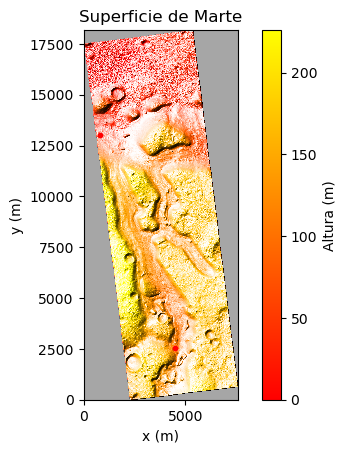

In [79]:
cmap = copy.copy(plt.cm.get_cmap('autumn'))
cmap.set_under(color='black')   

ls = LightSource(315, 45)
rgb = ls.shade(image_data, cmap=cmap, vmin = 0, vmax = image_data.max(), vert_exag=2, blend_mode='hsv')

fig, ax = plt.subplots()

im = ax.imshow(rgb, cmap=cmap, vmin = 0, vmax = image_data.max(), 
                extent =[0, scale*n_columns, 0, scale*n_rows], 
                interpolation ='nearest', origin ='upper')

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Altura (m)')

plt.title('Superficie de Marte')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

# Supongamos que quieres colocar un marcador en la coordenada (x_marker, y_marker)
x_marker = 1600
y_marker = 6398

# Marcador en forma de círculo, puedes personalizarlo según tus preferencias
# plt.scatter(4600, 3400, color='red', s=10, marker='o')
# plt.scatter(900, 12500, color='red', s=10, marker='o')
plt.scatter(4507, 2540, color='red', s=10, marker='o')
plt.scatter(804, 13000, color='red', s=10, marker='o')


plt.show()

# Hill Climbing

In [9]:
import time
import random
import math

In [10]:
class reg(object):
    def __init__(self, image_data, x_ini, y_ini, x_end, y_end):
        self.x_ini = x_ini # Guardamos las listas con los valores de x y y como un atributo de la clase
        self.y_ini = y_ini
        self.x_end = x_end
        self.y_end = y_end

        self.image_data = image_data

    def show(self): # Función que imprime los valores de los parámetros actuales
        print("x:", self.x_ini, "y:", self.y_ini)
        print("------------------------------------")

    def func(self, x): # Calculamos el valor de la función a partir de un valor específico de x y los parámetros actuales
        return math.sqrt((self.x_end - self.x_ini)**2 + (self.y_end - self.y_ini)**2)

    def cost(self):  # Calculamos el error máximo absoluto entre la función y los datos de entrada (y)
        return math.sqrt((self.x_end - self.x_ini)**2 + (self.y_end - self.y_ini)**2)

    def best_neighbor(self, pendiente_max):
        best_neighbor = self
        best_error = self.cost()
        
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue  # Evitar el punto actual
                neighbor_x = self.x_ini + dx
                neighbor_y = self.y_ini + dy
                if (0 <= neighbor_x < self.image_data.shape[1]) and (0 <= neighbor_y < self.image_data.shape[0]):
                    neighbor = reg(self.image_data, neighbor_x, neighbor_y, self.x_end, self.y_end)
                    neighbor_cost = neighbor.cost()
                    if abs(self.image_data[self.y_ini, self.x_ini] - self.image_data[neighbor_y, neighbor_x]) < pendiente_max:
                        if neighbor_cost < best_error:
                            best_neighbor = neighbor
                            best_error = neighbor_cost

        return best_neighbor




In [11]:
x_ini = 285
y_ini = 640
x_end = 315
y_end = 680

solution = reg(image_data, x_ini, y_ini, x_end, y_end)
solution.show()

cost = solution.cost()
print("Initial Cost: ", cost)

step = 0
max_steps = 250
while step < max_steps:
    step += 1

    neighbor = solution.best_neighbor(pendiente_max=0.75)
    new_cost = neighbor.cost()

    if new_cost < cost:
        solution = neighbor
        cost = new_cost

    print("Iteration: ", step, "    Cost: ", cost)
    neighbor.show()

print("\n--------Solution-----------")
solution.show()
print("Final Cost: ", cost)

x: 285 y: 640
------------------------------------
Initial Cost:  50.0
Iteration:  1     Cost:  48.60041152089147
x: 286 y: 641
------------------------------------
Iteration:  2     Cost:  47.20169488482379
x: 287 y: 642
------------------------------------
Iteration:  3     Cost:  45.803929962395145
x: 288 y: 643
------------------------------------
Iteration:  4     Cost:  44.40720662234904
x: 289 y: 644
------------------------------------
Iteration:  5     Cost:  43.01162633521314
x: 290 y: 645
------------------------------------
Iteration:  6     Cost:  42.20189569201838
x: 290 y: 646
------------------------------------
Iteration:  7     Cost:  40.80441152620633
x: 291 y: 647
------------------------------------
Iteration:  8     Cost:  39.408120990476064
x: 292 y: 648
------------------------------------
Iteration:  9     Cost:  38.01315561749642
x: 293 y: 649
------------------------------------
Iteration:  10     Cost:  36.61966684720111
x: 294 y: 650
-----------------------

In [12]:
image_data[640, 285]

111.30544433593765

In [13]:
image_data[640, 286]

111.31849609375014

In [14]:
x_ini = 286
y_ini = 640
x_end = 315
y_end = 680
for dx in [-1, 0, 1]:
    for dy in [-1, 0, 1]:
        if dx == 0 and dy == 0:
            continue  # Evitar el punto actual
        neighbor_x = x_ini + dx
        neighbor_y = y_ini + dy
        print(image_data[neighbor_y, neighbor_x])
        print('dif', abs(image_data[neighbor_y, neighbor_x] - image_data[y_ini, x_ini]))
        print('cost', math.sqrt((x_end - neighbor_x)**2 + (y_end - neighbor_y)**2))

111.07287597656264
dif 0.24562011718749943
cost 50.80354318352215
111.30544433593765
dif 0.013051757812490905
cost 50.0
111.62208984375015
dif 0.30359375000000455
cost 49.20365840057018
110.81391845703139
dif 0.50457763671875
cost 50.21951811795888
111.72565917968764
dif 0.4071630859374977
cost 48.60041152089147
111.0841577148439
dif 0.23433837890624432
cost 49.64876634922564
111.60292480468765
dif 0.28442871093750455
cost 48.82622246293481
111.71688964843764
dif 0.3983935546875017
cost 48.010415536631214
